# Speedband Prediction Model Training

This notebook trains an XGBoost model to predict the next speedband value for each link in the traffic network.

## Steps:
1. Setup and Data Loading
2. Data Analysis
3. Data Preprocessing
4. Feature Engineering
5. Train/Validation/Test Split
6. Model Training
7. Model Evaluation
8. Model Saving

In [2]:
# Install required packages
%pip install pandas numpy scikit-learn xgboost joblib pyarrow -q

In [3]:
# Import libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime
from typing import Tuple, Dict, Any
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 1: Upload Data File

Upload the `correlated_traffic_data.parquet` file using the file uploader below, or mount Google Drive if your file is stored there.

In [4]:
PARQUET_FILE = '/content/correlated_traffic_data.parquet'

print(f"Parquet file path: {PARQUET_FILE}")

Parquet file path: /content/correlated_traffic_data.parquet


## Step 2: Load and Analyze Data

In [5]:
# Load data
print("Loading data...")
df = pd.read_parquet(PARQUET_FILE)
print(f"Loaded {len(df):,} rows")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Loading data...
Loaded 9,633,729 rows
Columns: ['LinkID', 'generated_at', 'speedband', 'rainfall_mm', 'has_incident']

First few rows:


,LinkID,generated_at,speedband,rainfall_mm,has_incident
0,2,2026-01-15T01:01:30,4,0.0,False
1,3,2026-01-15T01:01:30,1,0.0,False
2,4,2026-01-15T01:01:30,1,0.0,False
3,5,2026-01-15T01:01:30,5,0.0,False
4,6,2026-01-15T01:01:30,3,0.0,False


In [6]:
# Basic data info
print("=" * 80)
print("Data Overview")
print("=" * 80)
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nBasic statistics:")
df.describe()

Data Overview
Shape: 9,633,729 rows × 5 columns

Data types:
LinkID           object
generated_at     object
speedband         int64
rainfall_mm     float64
has_incident       bool
dtype: object

Missing values:
LinkID          0
generated_at    0
speedband       0
rainfall_mm     0
has_incident    0
dtype: int64

Basic statistics:


,speedband,rainfall_mm
count,9.633729e+06,9.633729e+06
mean,3.062075e+00,3.470307e-04
std,1.646941e+00,1.442560e-02
min,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00
50%,3.000000e+00,0.000000e+00
75%,4.000000e+00,0.000000e+00
max,8.000000e+00,6.000000e-01


In [7]:
# Time series analysis
df['generated_at'] = pd.to_datetime(df['generated_at'])
print("Time Series Analysis:")
print(f"Date range: {df['generated_at'].min()} to {df['generated_at'].max()}")
print(f"Total time span: {df['generated_at'].max() - df['generated_at'].min()}")
print(f"Unique timestamps: {df['generated_at'].nunique()}")
print(f"Average records per timestamp: {len(df) / df['generated_at'].nunique():.1f}")
print(f"\nUnique links: {df['LinkID'].nunique()}")
print(f"Records per link: {df['LinkID'].value_counts().describe()}")

Time Series Analysis:
Date range: 2026-01-15 01:01:30 to 2026-01-15 16:07:07
Total time span: 0 days 15:05:37
Unique timestamps: 67
Average records per timestamp: 143787.0

Unique links: 143787
Records per link: count    143787.0
mean         67.0
std           0.0
min          67.0
25%          67.0
50%          67.0
75%          67.0
max          67.0
Name: count, dtype: float64


Speedband Distribution:
speedband
0       4489
1    1883772
2    2141693
3    2158110
4    1657397
5     972041
6     478215
7     205464
8     132548
Name: count, dtype: int64

Speedband statistics:
Min: 0, Max: 8
Mean: 3.06, Std: 1.65


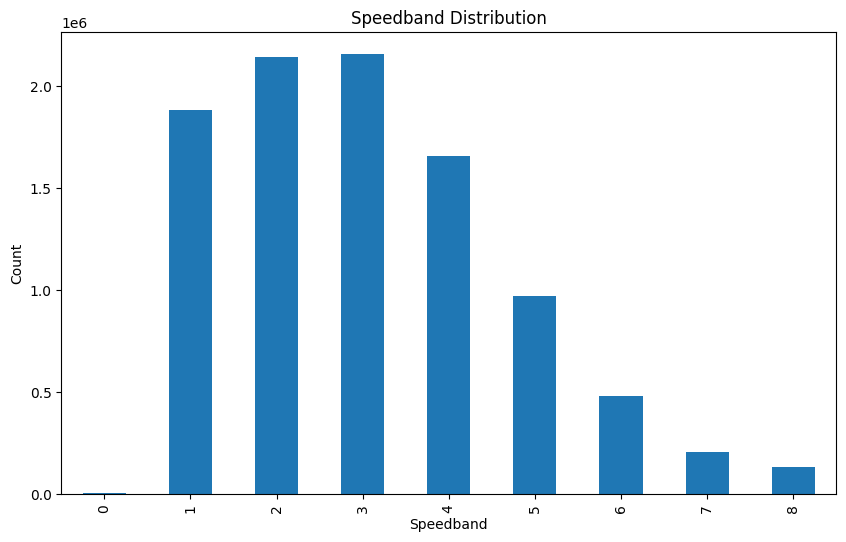

In [8]:
# Speedband distribution
print("Speedband Distribution:")
print(df['speedband'].value_counts().sort_index())
print(f"\nSpeedband statistics:")
print(f"Min: {df['speedband'].min()}, Max: {df['speedband'].max()}")
print(f"Mean: {df['speedband'].mean():.2f}, Std: {df['speedband'].std():.2f}")

# Visualize speedband distribution
plt.figure(figsize=(10, 6))
df['speedband'].value_counts().sort_index().plot(kind='bar')
plt.title('Speedband Distribution')
plt.xlabel('Speedband')
plt.ylabel('Count')
plt.show()

Correlation Matrix:
             speedband  rainfall_mm
speedband      1.00000      0.00421
rainfall_mm    0.00421      1.00000


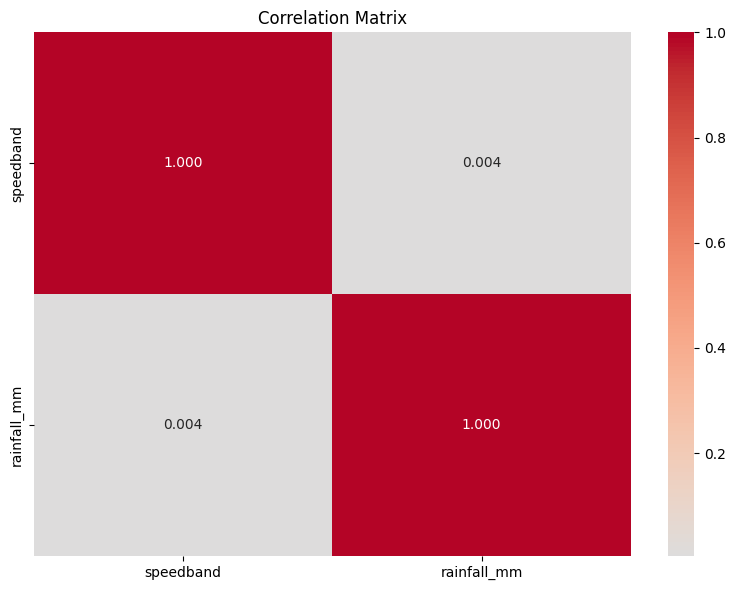


Correlations with speedband:
  rainfall_mm: 0.0042


In [9]:
# Correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) > 1:
    corr_matrix = df[numeric_cols].corr()
    print("Correlation Matrix:")
    print(corr_matrix)

    # Visualize correlation
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

    # Correlations with speedband
    if 'speedband' in corr_matrix.columns:
        print("\nCorrelations with speedband:")
        speedband_corr = corr_matrix['speedband'].sort_values(ascending=False, key=abs)
        for col, corr in speedband_corr.items():
            if col != 'speedband':
                print(f"  {col}: {corr:.4f}")

## Step 3: Data Preprocessing

In [10]:
# Preprocess data: convert timestamps, sort
print("=" * 80)
print("Step 1: Data Preprocessing")
print("=" * 80)

# Convert generated_at to datetime (if not already)
df['generated_at'] = pd.to_datetime(df['generated_at'])

# Sort by LinkID and timestamp to ensure proper ordering
print("Sorting by LinkID and timestamp...")
df = df.sort_values(['LinkID', 'generated_at']).reset_index(drop=True)

# Convert LinkID to categorical type for memory efficiency
print("Converting LinkID to categorical type...")
df['LinkID'] = df['LinkID'].astype('category')

print(f"Data shape: {df.shape}")
print(f"Date range: {df['generated_at'].min()} to {df['generated_at'].max()}")

Step 1: Data Preprocessing
Sorting by LinkID and timestamp...
Converting LinkID to categorical type...
Data shape: (9633729, 5)
Date range: 2026-01-15 01:01:30 to 2026-01-15 16:07:07


## Step 4: Feature Engineering

In [11]:
# Create features
print("=" * 80)
print("Step 2: Feature Engineering (Memory Optimized)")
print("=" * 80)

# Convert boolean to int8 for memory efficiency
df['has_incident'] = df['has_incident'].astype('int8')

# Time-based features
print("Creating time-based features...")
df['hour'] = df['generated_at'].dt.hour.astype('int8')
df['minute'] = df['generated_at'].dt.minute.astype('int8')

print("Creating lag and rolling features...")

# Lag features
df['speedband_lag1'] = df.groupby('LinkID')['speedband'].shift(1).astype(np.float32)
df['speedband_lag2'] = df.groupby('LinkID')['speedband'].shift(2).astype(np.float32)
df['speedband_lag3'] = df.groupby('LinkID')['speedband'].shift(3).astype(np.float32)
df['speedband_lag5'] = df.groupby('LinkID')['speedband'].shift(5).astype(np.float32)

# Rolling statistics over windows
for window in [3, 5, 10]:
    df[f'speedband_rolling_mean_{window}'] = df.groupby('LinkID')['speedband'].shift(1).rolling(window=window, min_periods=1).mean().astype(np.float32)
    df[f'speedband_rolling_std_{window}'] = df.groupby('LinkID')['speedband'].shift(1).rolling(window=window, min_periods=1).std().fillna(0).astype(np.float32)
    df[f'speedband_rolling_min_{window}'] = df.groupby('LinkID')['speedband'].shift(1).rolling(window=window, min_periods=1).min().astype(np.float32)
    df[f'speedband_rolling_max_{window}'] = df.groupby('LinkID')['speedband'].shift(1).rolling(window=window, min_periods=1).max().astype(np.float32)

# Number of changes in rolling window
# Ensure these are cast to smaller int types if possible
df['speedband_changes_3'] = (df.groupby('LinkID')['speedband'].shift(1).diff() != 0).astype('int8').groupby(df['LinkID']).rolling(window=3, min_periods=1).sum().reset_index(level=0, drop=True).astype('int8')
df['speedband_changes_5'] = (df.groupby('LinkID')['speedband'].shift(1).diff() != 0).astype('int8').groupby(df['LinkID']).rolling(window=5, min_periods=1).sum().reset_index(level=0, drop=True).astype('int8')

# Speedband change rate
df['speedband_diff'] = df.groupby('LinkID')['speedband'].shift(1).diff().fillna(0).astype(np.float32)

# Link-specific features (expanding) - can be memory intensive, cast to float32
df['link_avg_speedband'] = df.groupby('LinkID')['speedband'].shift(1).expanding().mean().reset_index(level=0, drop=True).astype(np.float32)
df['link_std_speedband'] = df.groupby('LinkID')['speedband'].shift(1).expanding().std().fillna(0).reset_index(level=0, drop=True).astype(np.float32)

# Rolling average of rainfall
for window in [3, 5]:
    df[f'rainfall_rolling_mean_{window}'] = df.groupby('LinkID')['rainfall_mm'].shift(1).rolling(window=window, min_periods=1).mean().astype(np.float32)

# Target variable: next speedband value
df['target'] = df.groupby('LinkID')['speedband'].shift(-1).astype(np.float32)

print("Feature engineering complete!")

Step 2: Feature Engineering (Memory Optimized)
Creating time-based features...
Creating lag and rolling features...


/tmp/ipython-input-1193270865.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['speedband_lag1'] = df.groupby('LinkID')['speedband'].shift(1).astype(np.float32)
/tmp/ipython-input-1193270865.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['speedband_lag2'] = df.groupby('LinkID')['speedband'].shift(2).astype(np.float32)
/tmp/ipython-input-1193270865.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['s

Feature engineering complete!


In [12]:
# Fill NaN values in lag features (first few rows per link) and drop rows with missing target
print("Filling NaN values in feature columns...")
# Identify columns that are likely to have NaNs from lag/rolling operations
feature_cols_to_fill = [col for col in df.columns if ('lag' in col or 'rolling' in col or 'link_' in col or 'speedband_diff' in col) and df[col].isnull().any()]

# Fill NaNs with median of the column or 0 for specific cases
for col in feature_cols_to_fill:
    # Using fillna(0) for counts and stds, median for means, or context-specific values
    if 'std' in col or 'changes' in col or 'diff' in col:
        df[col] = df[col].fillna(0)
    else:
        df[col] = df[col].fillna(df[col].median())

# Encode LinkID as categorical (using numeric encoding for XGBoost)
print("Encoding LinkID...")
df['LinkID_encoded'] = df['LinkID'].cat.codes.astype('int32')

# Drop rows where target is NaN (last row of each link)
print("Dropping rows with missing target...")
initial_rows = len(df)
df = df.dropna(subset=['target']).reset_index(drop=True)
print(f"Dropped {initial_rows - len(df):,} rows with missing target")

print(f"Final feature matrix shape: {df.shape}")
feature_cols = [c for c in df.columns if c not in ['LinkID', 'generated_at', 'speedband', 'target']]
print(f"Features created: {len(feature_cols)}")
print(f"Feature columns: {feature_cols[:10]}...")  # Show first 10

Filling NaN values in feature columns...
Encoding LinkID...
Dropping rows with missing target...
Dropped 143,787 rows with missing target
Final feature matrix shape: (9489942, 32)
Features created: 28
Feature columns: ['rainfall_mm', 'has_incident', 'hour', 'minute', 'speedband_lag1', 'speedband_lag2', 'speedband_lag3', 'speedband_lag5', 'speedband_rolling_mean_3', 'speedband_rolling_std_3']...


## Step 5: Train/Validation/Test Split

In [13]:
# Split data into train/validation/test sets using time-based split
print("=" * 80)
print("Step 3: Train/Validation/Test Split")
print("=" * 80)

train_dfs = []
val_dfs = []
test_dfs = []

print("Splitting by link (time-based split)...")
for link_id, group in df.groupby('LinkID'):
    group = group.sort_values('generated_at').reset_index(drop=True)
    n = len(group)

    # Split indices: 70% train, 15% val, 15% test
    train_end = int(n * 0.70)
    val_end = int(n * 0.85)

    train_dfs.append(group.iloc[:train_end])
    val_dfs.append(group.iloc[train_end:val_end])
    test_dfs.append(group.iloc[val_end:])

train_df = pd.concat(train_dfs, ignore_index=True)
val_df = pd.concat(val_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

print(f"Training set: {len(train_df):,} rows ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(val_df):,} rows ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_df):,} rows ({len(test_df)/len(df)*100:.1f}%)")

Step 3: Train/Validation/Test Split
Splitting by link (time-based split)...


/tmp/ipython-input-1688388293.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for link_id, group in df.groupby('LinkID'):


Training set: 6,614,202 rows (69.7%)
Validation set: 1,437,870 rows (15.2%)
Test set: 1,437,870 rows (15.2%)


In [14]:
# Prepare feature matrices
exclude_cols = ['LinkID', 'generated_at', 'speedband', 'target']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df['target']
X_val = val_df[feature_cols]
y_val = val_df['target']
X_test = test_df[feature_cols]
y_test = test_df['target']

print(f"Feature matrix shape: {X_train.shape}")
print(f"Number of features: {len(feature_cols)}")

Feature matrix shape: (6614202, 28)
Number of features: 28


## Step 6: Model Training

In [ ]:
# ... (Previous code remains the same)

print("Training XGBoost regressor...")

# XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 20,  # <--- MOVE IT HERE
}

# Initialize model with the parameters (including early_stopping_rounds)
model = xgb.XGBRegressor(**params)

# Train with early stopping
print("Training with early stopping on validation set...")

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    # early_stopping_rounds is removed from here
    verbose=100
)

print(f"\nBest iteration: {model.best_iteration}")
print(f"Best score: {model.best_score:.4f}")

Training XGBoost regressor...
Training with early stopping on validation set...


## Step 7: Model Evaluation

In [ ]:
# Evaluate model
print("=" * 80)
print("Step 6: Model Evaluation")
print("=" * 80)

def evaluate_model(model, X, y, dataset_name):
    """Evaluate model and return metrics."""
    print(f"\nEvaluating on {dataset_name} set...")

    # Predict
    y_pred = model.predict(X)

    # Clip predictions to valid range [0, 8]
    y_pred = np.clip(y_pred, 0, 8)

    # Calculate metrics
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mape = np.mean(np.abs((y - y_pred) / (y + 1e-8))) * 100
    y_pred_rounded = np.round(y_pred).astype(int)
    accuracy = (y_pred_rounded == y).mean() * 100

    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Accuracy': accuracy
    }

    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Accuracy (exact match): {accuracy:.2f}%")

    return metrics, y_pred

# Evaluate on all sets
train_metrics, y_train_pred = evaluate_model(model, X_train, y_train, "Training")
val_metrics, y_val_pred = evaluate_model(model, X_val, y_val, "Validation")
test_metrics, y_test_pred = evaluate_model(model, X_test, y_test, "Test")

In [ ]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, y_true, y_pred) in enumerate([
    ('Training', y_train, y_train_pred),
    ('Validation', y_val, y_val_pred),
    ('Test', y_test, y_test_pred)
]):
    axes[idx].scatter(y_true, y_pred, alpha=0.1, s=1)
    axes[idx].plot([0, 8], [0, 8], 'r--', lw=2)
    axes[idx].set_xlabel('Actual Speedband')
    axes[idx].set_ylabel('Predicted Speedband')
    axes[idx].set_title(f'{name} Set Predictions')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Feature importance
print("\nTop 20 Most Important Features:")
print("-" * 60)

importance = model.feature_importances_
indices = np.argsort(importance)[::-1][:20]

for i, idx in enumerate(indices, 1):
    print(f"{i:2d}. {feature_cols[idx]:40s} {importance[idx]:.4f}")

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = [feature_cols[idx] for idx in indices]
top_importance = [importance[idx] for idx in indices]
plt.barh(range(len(top_features)), top_importance)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Step 8: Save Model

In [ ]:
# Save model
print("=" * 80)
print("Step 5: Saving Model")
print("=" * 80)

# Create models directory
MODEL_DIR = '/content/models'
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_FILE = os.path.join(MODEL_DIR, 'speedband_model.joblib')
FEATURE_NAMES_FILE = os.path.join(MODEL_DIR, 'feature_names.txt')

print(f"Saving model to {MODEL_FILE}...")
joblib.dump(model, MODEL_FILE)

print(f"Saving feature names to {FEATURE_NAMES_FILE}...")
with open(FEATURE_NAMES_FILE, 'w') as f:
    for name in feature_cols:
        f.write(f"{name}\n")

print("Model saved successfully!")

In [ ]:
# Download model files (optional - to save to local machine)
from google.colab import files

# Download model
files.download(MODEL_FILE)

# Download feature names
files.download(FEATURE_NAMES_FILE)

print("Files downloaded!")

## Training Summary

In [ ]:
# Print final summary
print("=" * 80)
print("Training Summary")
print("=" * 80)
print(f"Training MAE: {train_metrics['MAE']:.4f}, Accuracy: {train_metrics['Accuracy']:.2f}%")
print(f"Validation MAE: {val_metrics['MAE']:.4f}, Accuracy: {val_metrics['Accuracy']:.2f}%")
print(f"Test MAE: {test_metrics['MAE']:.4f}, Accuracy: {test_metrics['Accuracy']:.2f}%")
print(f"\nModel saved to: {MODEL_FILE}")
print(f"End time: {datetime.now()}")
print("=" * 80)

## Make Predictions with the Saved Model

To use the saved model, you need to:
1. Load the model from the `.joblib` file.
2. Ensure your new data has the same features (and in the same order) as the data used for training.
3. Use the `predict` method of the loaded model.

In [ ]:
import joblib
import pandas as pd
import numpy as np
import os

# Define the path to the model and feature names files
MODEL_DIR = '/content/models'
MODEL_FILE = os.path.join(MODEL_DIR, 'speedband_model.joblib')
FEATURE_NAMES_FILE = os.path.join(MODEL_DIR, 'feature_names.txt')

# 1. Load the saved model
print(f"Loading model from {MODEL_FILE}...")
loaded_model = joblib.load(MODEL_FILE)
print("Model loaded successfully!")

# 2. Load the feature names used during training
print(f"Loading feature names from {FEATURE_NAMES_FILE}...")
with open(FEATURE_NAMES_FILE, 'r') as f:
    loaded_feature_cols = [line.strip() for line in f if line.strip()]
print(f"Loaded {len(loaded_feature_cols)} feature names.")

# Prepare sample data for prediction (using a small sample from X_test)
sample_size = 10
np.random.seed(42) # for reproducibility
sample_indices = np.random.choice(X_test.index, sample_size, replace=False)
X_sample = X_test.loc[sample_indices, loaded_feature_cols]
y_sample_actual = y_test.loc[sample_indices]

print(f"\nSample data for prediction (first {sample_size} rows):")
display(X_sample.head())

# 3. Make predictions on the sample data
print("Making predictions on the sample data...")
y_sample_pred = loaded_model.predict(X_sample)

# Clip predictions to the valid range [0, 8]
y_sample_pred_clipped = np.clip(y_sample_pred, 0, 8)

# Create a DataFrame to compare actual vs. predicted
results_df = pd.DataFrame({
    'Actual_Speedband': y_sample_actual,
    'Predicted_Speedband': y_sample_pred_clipped.round().astype(int),
    'Predicted_Raw': y_sample_pred_clipped
})

print("\nComparison of Actual vs. Predicted Speedbands for Sample Data:")
display(results_df)
